In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import cv2

image = Image.open(r"1024_0.jpg")
mask = cv2.imread(r"1024_0.png", cv2.IMREAD_GRAYSCALE)

# Convertir la imagen en un arreglo NumPy
image_array = np.array(image)
other_mask =  mask

# Aplicar el umbral (threshold)


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def overlay_mask(image, mask, mask_color=(0.0, 0, 0.5), alpha=0.9):
    # Crear una imagen RGB de la misma forma que la imagen original
    mask_rgb = np.zeros_like(image)

    # Asegurarse de que la máscara es binaria
    mask_binary = (mask > 0).astype(np.uint8)

    # Colorear los píxeles de interés en la máscara
    mask_rgb[mask_binary == 1] = mask_color

    # Superponer la máscara a la imagen utilizando una mezcla ponderada
    overlay = cv2.addWeighted(image, 0.5, mask_rgb, alpha, 0)

    return overlay


# Asegúrate de que image_array y other_mask están definidos y tienen las mismas dimensiones
image_overlay = overlay_mask(image_array, other_mask)

segments_slic = slic(image_overlay, n_segments=100, compactness=5, sigma=1)

image_slic = mark_boundaries(image_overlay, segments_slic)

plt.imsave('superpuesta.png', image_slic)
plt.show()

In [9]:
import pandas as pd


def create_masks(img, segments_slic):
    superPixels = []
    masks = []
    for i in range(np.max(segments_slic) + 1):
        superPixels.append(np.where(segments_slic == i))
        mask = np.zeros(img.shape, dtype="uint8")
        mask[superPixels[i]] = 255
        masks.append(mask[:, :, 0])
    return masks, superPixels


def detector(mask_ref, superPixels, segments_slic, mean_min):
    clas = []  # se guardara el número de superpixel que contiene lesión
    wound = []  # Se etiquetara al superpixel
    for i in range(np.max(segments_slic) + 1):
        if np.mean(mask_ref[superPixels[i]]) > mean_min:
            clas.append(i)
            wound.append(1)
        else:
            wound.append(0)
    ctd_sup = len(clas)  # cantidad de superpixeles necesarios para cubrir la lesión
    return clas, wound, ctd_sup

# función solo para crear mascara con superpixeles


def create_mask_sp(img, segments_slic, clas):
    marcadores = []
    for i in clas:
        marcadores.append(np.where(segments_slic == i))

    # creamos la máscara usando superpixeles
    mask_sp = np.zeros(img.shape, dtype="uint8")
    for idx in range(len(marcadores)):
        mask_sp[marcadores[idx]] = 255
    return mask_sp


if segments_slic[0][0] != 0:
    segments_slic = segments_slic - 1  # segments_slic has to start at 0
masks, positions_pxl = create_masks(image_array, segments_slic)
# la imagen debe estar en formato RGB
clas, wound, ctd_s_pxl = detector(other_mask, positions_pxl, segments_slic, 180)

df_wound = pd.DataFrame({'Wound': wound})
y_test_g = df_wound.Wound

clas, wound, ctd_s_pxl = detector(other_mask, positions_pxl, segments_slic, 180)
df_wound = pd.DataFrame({'Wound': wound})
y_test_s = df_wound.Wound

In [10]:
mask_sliced = create_mask_sp(image_array, segments_slic, clas)
mask_sliced = cv2.cvtColor(mask_sliced, cv2.COLOR_RGB2GRAY)

In [11]:
import numpy as np


def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou


iou = calculate_iou(mask_sliced, other_mask)
print("IoU:", iou)

IoU: 0.9183746001658571


In [12]:
plt.imsave('mask_sliced.png', mask_sliced)
plt.imsave('other_mask.png', other_mask)

In [19]:
import numpy as np
from skimage.segmentation import slic
from keras.applications.vgg16 import VGG16
import tool
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from numpy import expand_dims
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.transform import resize
from keras.applications.vgg16 import VGG16
from skimage.segmentation import mark_boundaries

# Extraer caracteristicas de color para una sola imagen


def feature_color(img, ch, sup_pxls, segments_slic):
    var_ch = []
    me_ch = []

    for i in range(np.max(segments_slic) + 1):
        img_ch = img[:, :, ch][sup_pxls[i]]
        var_ch.append(np.var(img_ch))
        me_ch.append(np.mean(img_ch))

    return var_ch, me_ch


def features_maps_VGG16(model, img, layer):
    # redefine model to output right after the first hidden layer
    model = Model(inputs=model.inputs, outputs=model.layers[layer].output)
    # model.summary()
    # load the image with the required shape

    height, width, ch = img.shape
    img = cv2.resize(img, (224, 224))

    img = expand_dims(img, axis=0)
    # prepare the image (e.g. scale pixel values for the vgg)
    img = preprocess_input(img)
    # get feature map for first hidden layer
    feature_maps = model.predict(img)
    feature_maps = feature_maps[0, :, :, :]
    feature_maps = resize(feature_maps, (height, width, feature_maps.shape[2]))

    return feature_maps


def feature_slic_RGB(img, n_segment, compactness, sigma, layer):
    var_ch_img = []
    me_ch_img = []

    segments_slic = slic(img, n_segment, compactness=compactness, sigma=sigma)
    if segments_slic[0][0] != 0:
        segments_slic = segments_slic - 1  # segments_slic has to start at 0
    masks, positions_pxl = tool.create_masks(img, segments_slic)
    x, y = tool.centroide(masks, segments_slic)

    channels = img.shape[2]  # number of channels

    for ch in range(channels):
        var_ch_sp, me_ch_sp = feature_color(img, ch, positions_pxl, segments_slic)  # channel red
        var_ch_img.append(var_ch_sp)
        me_ch_img.append(me_ch_sp)

    var_ch_img = np.array(var_ch_img).T
    me_ch_img = np.array(me_ch_img).T

    return np.c_[x, y, var_ch_img, me_ch_img]


def feature_slic_VGG16(img, n_segment, compactness, sigma, layer):
    model = VGG16()
    var_ch_img = []
    me_ch_img = []

    segments_slic = slic(img, n_segment, compactness=compactness, sigma=sigma)
    if segments_slic[0][0] != 0:
        segments_slic = segments_slic - 1  # segments_slic has to start at 0
    masks, positions_pxl = tool.create_masks(img, segments_slic)
    x, y = tool.centroide(masks, segments_slic)

    img = features_maps_VGG16(model, img, layer)
    channels = img.shape[2]  # number of channels

    for ch in range(channels):
        var_ch_sp, me_ch_sp = feature_color(img, ch, positions_pxl, segments_slic)  # channel red
        var_ch_img.append(var_ch_sp)
        me_ch_img.append(me_ch_sp)

    var_ch_img = np.array(var_ch_img).T
    me_ch_img = np.array(me_ch_img).T

    return np.c_[x, y, var_ch_img, me_ch_img]


def feature_slic_RGB_VGG16(img, n_segment, compactness, sigma, layer):
    model = VGG16()
    var_ch_img = []
    me_ch_img = []

    segments_slic = slic(img, n_segment, compactness=compactness, sigma=sigma)

    if segments_slic[0][0] != 0:
        segments_slic = segments_slic - 1  # segments_slic has to start at 0
    masks, positions_pxl = tool.create_masks(img, segments_slic)
    x, y = tool.centroide(masks, segments_slic)

    channels = img.shape[2]  # number of channels

    for ch in range(channels):
        var_ch_sp, me_ch_sp = feature_color(img, ch, positions_pxl, segments_slic)  # channel red
        var_ch_img.append(var_ch_sp)
        me_ch_img.append(me_ch_sp)

    img = features_maps_VGG16(model, img, layer)
    channels = img.shape[2]  # number of channels

    for ch in range(channels):
        var_ch_sp, me_ch_sp = feature_color(img, ch, positions_pxl, segments_slic)  # channel red
        var_ch_img.append(var_ch_sp)
        me_ch_img.append(me_ch_sp)

    var_ch_img = np.array(var_ch_img).T
    me_ch_img = np.array(me_ch_img).T

    return np.c_[x, y, var_ch_img, me_ch_img]

In [20]:
img = cv2.imread('1024_0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

n_segment = 100
compactness = 5
sigma = 1
layer = 5

df = feature_slic_VGG16(img, n_segment, compactness, sigma, layer)

1/1 [==============================] - 0s 281ms/step


In [32]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Cargar los datos desde el archivo CSV
data = pd.read_csv('data/Experiment_sample_Jordi_VGG16_feature_vector_VGG.csv')
data['Wound'] = data['Wound'].fillna(0)
# data = pd.read_csv('data/Experiment_sample_Jordi_RGB_VGG16_feature_vector_RGB-VGG.csv')
data = data.values[:, 2:]

# column_name_RGB = ['x_c', 'y_c', 'var_ch_1', 'var_ch_2', 'var_ch_3', 'mean_ch_1', 'mean_ch_2', 'mean_ch_3']

# column_name_VGG16 = ['x_c', 'y_c', 'var_ch_1', 'var_ch_2', 'var_ch_3', 'var_ch_4', 'var_ch_5', 'var_ch_6', 'var_ch_7', 'var_ch_8', 'var_ch_9', 'var_ch_10', 'var_ch_11', 'var_ch_12', 'var_ch_13', 'var_ch_14', 'var_ch_15', 'var_ch_16', 'var_ch_17', 'var_ch_18', 'var_ch_19', 'var_ch_20', 'var_ch_21', 'var_ch_22', 'var_ch_23', 'var_ch_24', 'var_ch_25', 'var_ch_26', 'var_ch_27', 'var_ch_28', 'var_ch_29', 'var_ch_30', 'var_ch_31', 'var_ch_32', 'var_ch_33', 'var_ch_34', 'var_ch_35', 'var_ch_36', 'var_ch_37', 'var_ch_38', 'var_ch_39', 'var_ch_40', 'var_ch_41', 'var_ch_42', 'var_ch_43', 'var_ch_44', 'var_ch_45', 'var_ch_46', 'var_ch_47', 'var_ch_48', 'var_ch_49', 'var_ch_50', 'var_ch_51', 'var_ch_52', 'var_ch_53', 'var_ch_54', 'var_ch_55', 'var_ch_56', 'var_ch_57', 'var_ch_58', 'var_ch_59', 'var_ch_60', 'var_ch_61', 'var_ch_62', 'var_ch_63', 'var_ch_64', 'var_ch_65', 'var_ch_66', 'var_ch_67', 'var_ch_68', 'var_ch_69', 'var_ch_70', 'var_ch_71', 'var_ch_72', 'var_ch_73', 'var_ch_74', 'var_ch_75', 'var_ch_76', 'var_ch_77', 'var_ch_78', 'var_ch_79', 'var_ch_80', 'var_ch_81', 'var_ch_82', 'var_ch_83', 'var_ch_84', 'var_ch_85', 'var_ch_86', 'var_ch_87', 'var_ch_88', 'var_ch_89', 'var_ch_90', 'var_ch_91', 'var_ch_92', 'var_ch_93', 'var_ch_94', 'var_ch_95', 'var_ch_96', 'var_ch_97', 'var_ch_98', 'var_ch_99', 'var_ch_100', 'var_ch_101', 'var_ch_102', 'var_ch_103', 'var_ch_104', 'var_ch_105', 'var_ch_106', 'var_ch_107', 'var_ch_108', 'var_ch_109', 'var_ch_110', 'var_ch_111', 'var_ch_112', 'var_ch_113', 'var_ch_114', 'var_ch_115', 'var_ch_116', 'var_ch_117', 'var_ch_118', 'var_ch_119', 'var_ch_120', 'var_ch_121', 'var_ch_122', 'var_ch_123', 'var_ch_124', 'var_ch_125', 'var_ch_126', 'var_ch_127', 'var_ch_128', 'mean_ch_1', 'mean_ch_2', 'mean_ch_3', 'mean_ch_4',
#                      'mean_ch_5', 'mean_ch_6', 'mean_ch_7', 'mean_ch_8', 'mean_ch_9', 'mean_ch_10', 'mean_ch_11', 'mean_ch_12', 'mean_ch_13', 'mean_ch_14', 'mean_ch_15', 'mean_ch_16', 'mean_ch_17', 'mean_ch_18', 'mean_ch_19', 'mean_ch_20', 'mean_ch_21', 'mean_ch_22', 'mean_ch_23', 'mean_ch_24', 'mean_ch_25', 'mean_ch_26', 'mean_ch_27', 'mean_ch_28', 'mean_ch_29', 'mean_ch_30', 'mean_ch_31', 'mean_ch_32', 'mean_ch_33', 'mean_ch_34', 'mean_ch_35', 'mean_ch_36', 'mean_ch_37', 'mean_ch_38', 'mean_ch_39', 'mean_ch_40', 'mean_ch_41', 'mean_ch_42', 'mean_ch_43', 'mean_ch_44', 'mean_ch_45', 'mean_ch_46', 'mean_ch_47', 'mean_ch_48', 'mean_ch_49', 'mean_ch_50', 'mean_ch_51', 'mean_ch_52', 'mean_ch_53', 'mean_ch_54', 'mean_ch_55', 'mean_ch_56', 'mean_ch_57', 'mean_ch_58', 'mean_ch_59', 'mean_ch_60', 'mean_ch_61', 'mean_ch_62', 'mean_ch_63', 'mean_ch_64', 'mean_ch_65', 'mean_ch_66', 'mean_ch_67', 'mean_ch_68', 'mean_ch_69', 'mean_ch_70', 'mean_ch_71', 'mean_ch_72', 'mean_ch_73', 'mean_ch_74', 'mean_ch_75', 'mean_ch_76', 'mean_ch_77', 'mean_ch_78', 'mean_ch_79', 'mean_ch_80', 'mean_ch_81', 'mean_ch_82', 'mean_ch_83', 'mean_ch_84', 'mean_ch_85', 'mean_ch_86', 'mean_ch_87', 'mean_ch_88', 'mean_ch_89', 'mean_ch_90', 'mean_ch_91', 'mean_ch_92', 'mean_ch_93', 'mean_ch_94', 'mean_ch_95', 'mean_ch_96', 'mean_ch_97', 'mean_ch_98', 'mean_ch_99', 'mean_ch_100', 'mean_ch_101', 'mean_ch_102', 'mean_ch_103', 'mean_ch_104', 'mean_ch_105', 'mean_ch_106', 'mean_ch_107', 'mean_ch_108', 'mean_ch_109', 'mean_ch_110', 'mean_ch_111', 'mean_ch_112', 'mean_ch_113', 'mean_ch_114', 'mean_ch_115', 'mean_ch_116', 'mean_ch_117', 'mean_ch_118', 'mean_ch_119', 'mean_ch_120', 'mean_ch_121', 'mean_ch_122', 'mean_ch_123', 'mean_ch_124', 'mean_ch_125', 'mean_ch_126', 'mean_ch_127', 'mean_ch_128']

# column_name_RGB_VGG16 = ['x_c', 'y_c', 'var_ch_1', 'var_ch_2', 'var_ch_3', 'mean_ch_1', 'mean_ch_2', 'mean_ch_3', 'var_ch_1', 'var_ch_2', 'var_ch_3', 'var_ch_4', 'var_ch_5', 'var_ch_6', 'var_ch_7', 'var_ch_8', 'var_ch_9', 'var_ch_10', 'var_ch_11', 'var_ch_12', 'var_ch_13', 'var_ch_14', 'var_ch_15', 'var_ch_16', 'var_ch_17', 'var_ch_18', 'var_ch_19', 'var_ch_20', 'var_ch_21', 'var_ch_22', 'var_ch_23', 'var_ch_24', 'var_ch_25', 'var_ch_26', 'var_ch_27', 'var_ch_28', 'var_ch_29', 'var_ch_30', 'var_ch_31', 'var_ch_32', 'var_ch_33', 'var_ch_34', 'var_ch_35', 'var_ch_36', 'var_ch_37', 'var_ch_38', 'var_ch_39', 'var_ch_40', 'var_ch_41', 'var_ch_42', 'var_ch_43', 'var_ch_44', 'var_ch_45', 'var_ch_46', 'var_ch_47', 'var_ch_48', 'var_ch_49', 'var_ch_50', 'var_ch_51', 'var_ch_52', 'var_ch_53', 'var_ch_54', 'var_ch_55', 'var_ch_56', 'var_ch_57', 'var_ch_58', 'var_ch_59', 'var_ch_60', 'var_ch_61', 'var_ch_62', 'var_ch_63', 'var_ch_64', 'var_ch_65', 'var_ch_66', 'var_ch_67', 'var_ch_68', 'var_ch_69', 'var_ch_70', 'var_ch_71', 'var_ch_72', 'var_ch_73', 'var_ch_74', 'var_ch_75', 'var_ch_76', 'var_ch_77', 'var_ch_78', 'var_ch_79', 'var_ch_80', 'var_ch_81', 'var_ch_82', 'var_ch_83', 'var_ch_84', 'var_ch_85', 'var_ch_86', 'var_ch_87', 'var_ch_88', 'var_ch_89', 'var_ch_90', 'var_ch_91', 'var_ch_92', 'var_ch_93', 'var_ch_94', 'var_ch_95', 'var_ch_96', 'var_ch_97', 'var_ch_98', 'var_ch_99', 'var_ch_100', 'var_ch_101', 'var_ch_102', 'var_ch_103', 'var_ch_104', 'var_ch_105', 'var_ch_106', 'var_ch_107', 'var_ch_108', 'var_ch_109', 'var_ch_110', 'var_ch_111', 'var_ch_112', 'var_ch_113', 'var_ch_114', 'var_ch_115', 'var_ch_116', 'var_ch_117', 'var_ch_118', 'var_ch_119', 'var_ch_120', 'var_ch_121', 'var_ch_122', 'var_ch_123', 'var_ch_124', 'var_ch_125', 'var_ch_126', 'var_ch_127', 'var_ch_128', 'mean_ch_1', 'mean_ch_2', 'mean_ch_3', 'mean_ch_4',
#                          'mean_ch_5', 'mean_ch_6', 'mean_ch_7', 'mean_ch_8', 'mean_ch_9', 'mean_ch_10', 'mean_ch_11', 'mean_ch_12', 'mean_ch_13', 'mean_ch_14', 'mean_ch_15', 'mean_ch_16', 'mean_ch_17', 'mean_ch_18', 'mean_ch_19', 'mean_ch_20', 'mean_ch_21', 'mean_ch_22', 'mean_ch_23', 'mean_ch_24', 'mean_ch_25', 'mean_ch_26', 'mean_ch_27', 'mean_ch_28', 'mean_ch_29', 'mean_ch_30', 'mean_ch_31', 'mean_ch_32', 'mean_ch_33', 'mean_ch_34', 'mean_ch_35', 'mean_ch_36', 'mean_ch_37', 'mean_ch_38', 'mean_ch_39', 'mean_ch_40', 'mean_ch_41', 'mean_ch_42', 'mean_ch_43', 'mean_ch_44', 'mean_ch_45', 'mean_ch_46', 'mean_ch_47', 'mean_ch_48', 'mean_ch_49', 'mean_ch_50', 'mean_ch_51', 'mean_ch_52', 'mean_ch_53', 'mean_ch_54', 'mean_ch_55', 'mean_ch_56', 'mean_ch_57', 'mean_ch_58', 'mean_ch_59', 'mean_ch_60', 'mean_ch_61', 'mean_ch_62', 'mean_ch_63', 'mean_ch_64', 'mean_ch_65', 'mean_ch_66', 'mean_ch_67', 'mean_ch_68', 'mean_ch_69', 'mean_ch_70', 'mean_ch_71', 'mean_ch_72', 'mean_ch_73', 'mean_ch_74', 'mean_ch_75', 'mean_ch_76', 'mean_ch_77', 'mean_ch_78', 'mean_ch_79', 'mean_ch_80', 'mean_ch_81', 'mean_ch_82', 'mean_ch_83', 'mean_ch_84', 'mean_ch_85', 'mean_ch_86', 'mean_ch_87', 'mean_ch_88', 'mean_ch_89', 'mean_ch_90', 'mean_ch_91', 'mean_ch_92', 'mean_ch_93', 'mean_ch_94', 'mean_ch_95', 'mean_ch_96', 'mean_ch_97', 'mean_ch_98', 'mean_ch_99', 'mean_ch_100', 'mean_ch_101', 'mean_ch_102', 'mean_ch_103', 'mean_ch_104', 'mean_ch_105', 'mean_ch_106', 'mean_ch_107', 'mean_ch_108', 'mean_ch_109', 'mean_ch_110', 'mean_ch_111', 'mean_ch_112', 'mean_ch_113', 'mean_ch_114', 'mean_ch_115', 'mean_ch_116', 'mean_ch_117', 'mean_ch_118', 'mean_ch_119', 'mean_ch_120', 'mean_ch_121', 'mean_ch_122', 'mean_ch_123', 'mean_ch_124', 'mean_ch_125', 'mean_ch_126', 'mean_ch_127', 'mean_ch_128']

# label = "Wound"


# data_x_train = pd.read_csv('Models/Data_train/X_train.csv').values
# data_y_train = pd.read_csv('Models/Data_train/y_train.csv').values[:, 1]

# Ajustar el modelo a los datos
X = data[:, :-1].astype(dtype=float)
y = data[:, -1].astype(dtype=int)

# Crear el modelo de regresión logística
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_RL = LogisticRegression(max_iter=100)


In [33]:
%%time
# Ajustar el modelo a los datos
model_RL.fit(X_train, y_train)


CPU times: user 637 ms, sys: 85.9 ms, total: 723 ms
Wall time: 370 ms


LogisticRegression()

In [34]:
# prediction = model_RL.predict(X_test)
probabilities = model_RL.predict_proba(X_train)

prediction = model_RL.predict(df[:, :])
probabilities = model_RL.predict_proba(df[:, :])

In [35]:
print("Número de iteraciones: ", model_RL.n_iter_[0])

Número de iteraciones:  100


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Supongamos que ya tienes tus datos de entrenamiento y prueba: X_train, y_train, X_test, y_test

# Crear y entrenar el modelo de regresión logística
# Realizar predicciones en el conjunto de prueba
y_pred = model_RL.predict(X_test)

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas
print("Exactitud: {:.2f}".format(accuracy))
print("Precisión: {:.2f}".format(precision))
print("Sensibilidad: {:.2f}".format(recall))
print("Valor F1: {:.2f}".format(f1))

Exactitud: 0.86
Precisión: 0.78
Sensibilidad: 0.83
Valor F1: 0.80


In [37]:
def select_points_for_SAM(model_RL, test, k):
    probabilities = model_RL.predict_proba(test[:, :])

    indices_0 = np.argsort(probabilities[:, 0])[::-1]
    indices_1 = np.argsort(probabilities[:, 1])[::-1]

    data_0 = df[indices_0]
    data_1 = df[indices_1]

    return data_1[:k, [0, 1]], data_0[:k, [0, 1]]

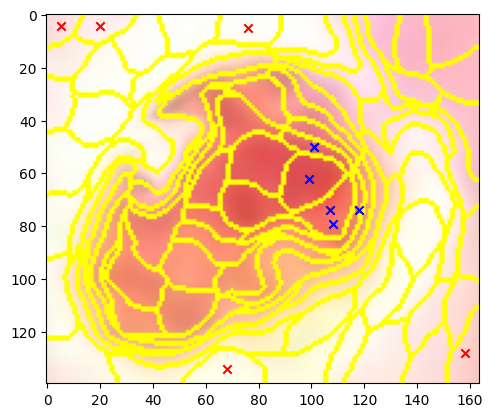

In [38]:
k = 5

selected_points_p, selected_points_n = select_points_for_SAM(model_RL, df, k)
segments_slic = slic(img, n_segment, compactness=compactness, sigma=sigma)
boundaries_sp = mark_boundaries(img, segments_slic)

plt.imshow(boundaries_sp)
plt.scatter(selected_points_p[:, 0], selected_points_p[:, 1], marker='x', c='b')
plt.scatter(selected_points_n[:, 0], selected_points_n[:, 1], marker='x', c='r')
plt.show()